In [ ]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=249ec2f979f57d14830df6fff7a7fcb98c74bcad72866eafa39af091a7e0eaa9
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
import albumentations as A
import cv2
import numpy as np
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
import albumentations as albu
from scipy.signal import convolve2d
import math
import cv2
from skimage.restoration import estimate_sigma
from matplotlib.colors import ListedColormap

IMAGE_SIZE=256

In [ ]:
save_path="oct/oct images/segmentation_data/segmentation_data/records/imagesgreyscal"
source_path="oct/oct images/segmentation_data/segmentation_data/records/imagesgreyscale"
target_path=Path("oct/oct images/retouch/oct/topcon")
target_path2=Path("oct/oct images/retouch/oct/cirrus")
target_path3=Path("oct/oct images/bioptigen/images")

In [ ]:
def readIm(imagepath):
  image = cv2.imread(str(imagepath),0)
  return image

In [ ]:
def get_random_images(path,length=1):
    all_images = sorted(Path(path).glob("*.png"))
    return np.random.choice(all_images, length,replace=False)

In [ ]:
def svdna(k,target_path,src_path,histo_matching_degree=0.5):

    target_img = Image.open(target_path).convert("L")
    src_img = Image.open(src_path).convert("L")


    resized_target=np.array(target_img.resize((IMAGE_SIZE,IMAGE_SIZE), Image.NEAREST))
    resized_src=np.array(src_img.resize((IMAGE_SIZE,IMAGE_SIZE), Image.NEAREST))

    u_target,s_target,vh_target=np.linalg.svd(resized_target,full_matrices=False)
    u_source,s_source,vh_source=np.linalg.svd(resized_src,full_matrices=False)

    thresholded_singular_target=s_target
    thresholded_singular_target[0:k]=0

    thresholded_singular_source=s_source
    thresholded_singular_source[k:]=0

    target_style=np.array([np.dot(u_target, np.dot(np.diag(thresholded_singular_target), vh_target))])

    content_src=np.array([np.dot(u_source, np.dot(np.diag(thresholded_singular_source), vh_source))])
    content_trgt=resized_target-target_style

    noise_adapted_im=content_src+target_style

    noise_adapted_im_clipped=np.squeeze(noise_adapted_im).clip(0,255).astype(np.uint8)

    transformHist = A.Compose([
        A.HistogramMatching([target_path], blend_ratio=(histo_matching_degree, histo_matching_degree), read_fn=readIm, p=1)
    ])

    image = np.array(Image.open(src_path).resize((IMAGE_SIZE,IMAGE_SIZE)))

    transformed = transformHist(image=noise_adapted_im_clipped)
    svdna_im = transformed["image"]

    return resized_src,resized_target,content_src,np.squeeze(target_style), svdna_im,noise_adapted_im_clipped


In [ ]:
def signaltonoise(a, axis=0, delta_degre_of_freedom=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=delta_degre_of_freedom)
    return np.where(sd == 0, 0, m/sd)

In [ ]:
def estimate_noise(I):

  H, W = I.shape

  M = [[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]]

  sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
  sigma = sigma * math.sqrt(0.5 * math.pi) / (6 * (W-2) * (H-2))

  return sigma

In [ ]:
def get_all_statistics(source_path,target_paths):
    all_ims=[]
    all_src=sorted(Path(source_path).glob("*.png"))
    df=pd.DataFrame()
    for j,target_path in enumerate(target_paths):
        random_targets=get_random_images(str(target_path),len(all_src))

        for i,(source_im,target_im) in enumerate(zip(all_src,random_targets)):
            resized_src,resized_target,_,_,svdna_im,_=svdna(30,str(target_im),str(source_im))
            if j==0: df=df.append(get_statistics(resized_src,"source"),ignore_index=True)
            df=df.append(get_statistics(resized_target,"target"+str(j)),ignore_index=True)
            df=df.append(get_statistics(svdna_im,"stt"+str(j)),ignore_index=True)
            print("\r {}".format("Measuring " +str(i+1) + " of " + str(int(len(all_src)))+ " completed."), end="")

    return df

def get_statistics(im,domain):
    signal_to_noise=signaltonoise(im,axis=None)
    noise_estimation=estimate_noise(im)
    sig=estimate_sigma(im)
    pd_entry={"domain": domain,"signal_to_noise":signal_to_noise,"noise_est":noise_estimation,"sig":sig}
    return pd_entry

In [ ]:
resized_src,resized_target,content_src,target_style, svdna_im,noise_adapted_im_clipped=svdna(50,"/content/im2.png","/content/im1.png")




Text(0.5, 1.0, '')

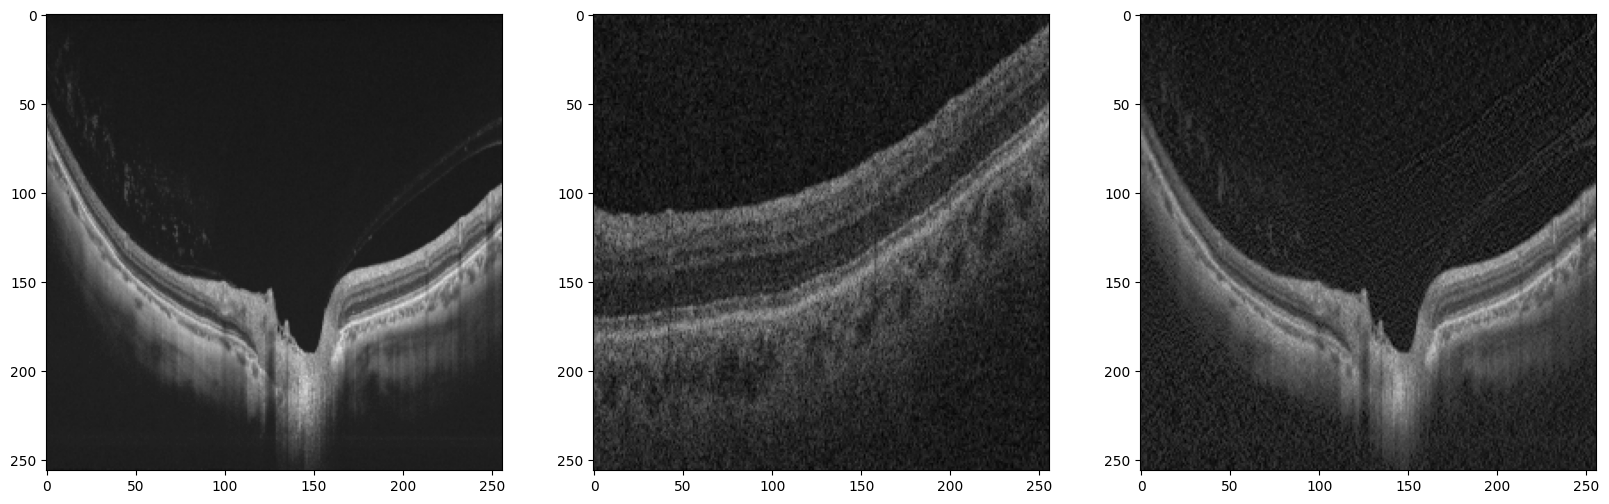

In [ ]:
fig = plt.figure(figsize=(20,20))

ax3 = fig.add_subplot(1,3,1)

ax3.imshow(resized_src,cmap="gray",vmin=0,vmax=255)
plt.title('',fontsize=30)

ax2 = fig.add_subplot(1,3,2)

ax2.imshow(resized_target,cmap="gray",vmin=0,vmax=255)
plt.title('',fontsize=30)

ax4 = fig.add_subplot(1,3,3)

ax4.imshow(svdna_im,cmap="gray",vmin=0,vmax=255)
plt.title('',fontsize=30)



In [ ]:
all_stats=get_all_statistics(source_path,[target_path,target_path2,target_path3])
scaled_stats=StandardScaler().fit_transform(all_stats)
reducer = umap.UMAP()
embedding=reducer.fit_transform(scaled_stats)

In [ ]:
scaled_stats

array([[-1.37406601, -0.12230318, -0.06769137],
       [ 0.92048755, -0.23315568, -0.19970446],
       [ 1.00058445, -0.62656536, -0.65306904],
       ...,
       [ 0.37036914, -0.38008042, -0.3727064 ],
       [-0.3836229 ,  2.29284618,  2.2898835 ],
       [ 0.20289688, -0.38098832, -0.36632328]])

Text(0.5, 1.0, 'Cross-domain noise embeddings')

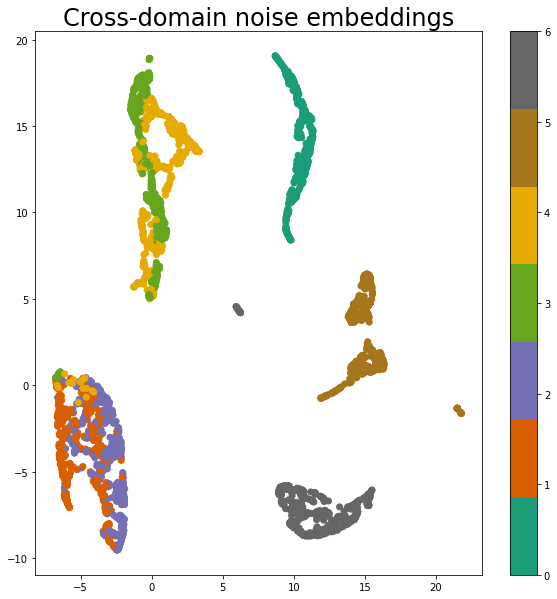

In [ ]:
plt.figure(figsize=(10,10))
my_cmap = ListedColormap(sns.color_palette().as_hex())
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[x for x in all_stats.domain.map({"source":0, "target0":1, "stt0":2, "target1":3, "stt1":4,"target2":5, "stt2":6})],cmap=plt.get_cmap("Dark2",7))
plt.colorbar()
plt.title("Cross-domain noise embeddings", fontsize=24)




In [ ]:
resized_src,resized_target,content_src,target_style, svdna_im,noise_adapted_im_clipped=svdna(40,"/content/Farsiu_Ophthalmology_2013_AMD_Subject_102575.png","/content/3-75.png")

In [ ]:
resized_src,resized_cirrus,_,_, svdna_im_cirrus,_=svdna(40,path_to_src_image,path_to_cirrus_image)
resized_src,resized_topcon,_,_, svdna_im_topcon,_=svdna(40,path_to_src_image,path_to_topcon_image)
resized_src,resized_bioptigen,_,_, svdna_im_bioptigen,_=svdna(40,path_to_src_image,path_to_bioptigen_image)

(-0.5, 255.5, 255.5, -0.5)

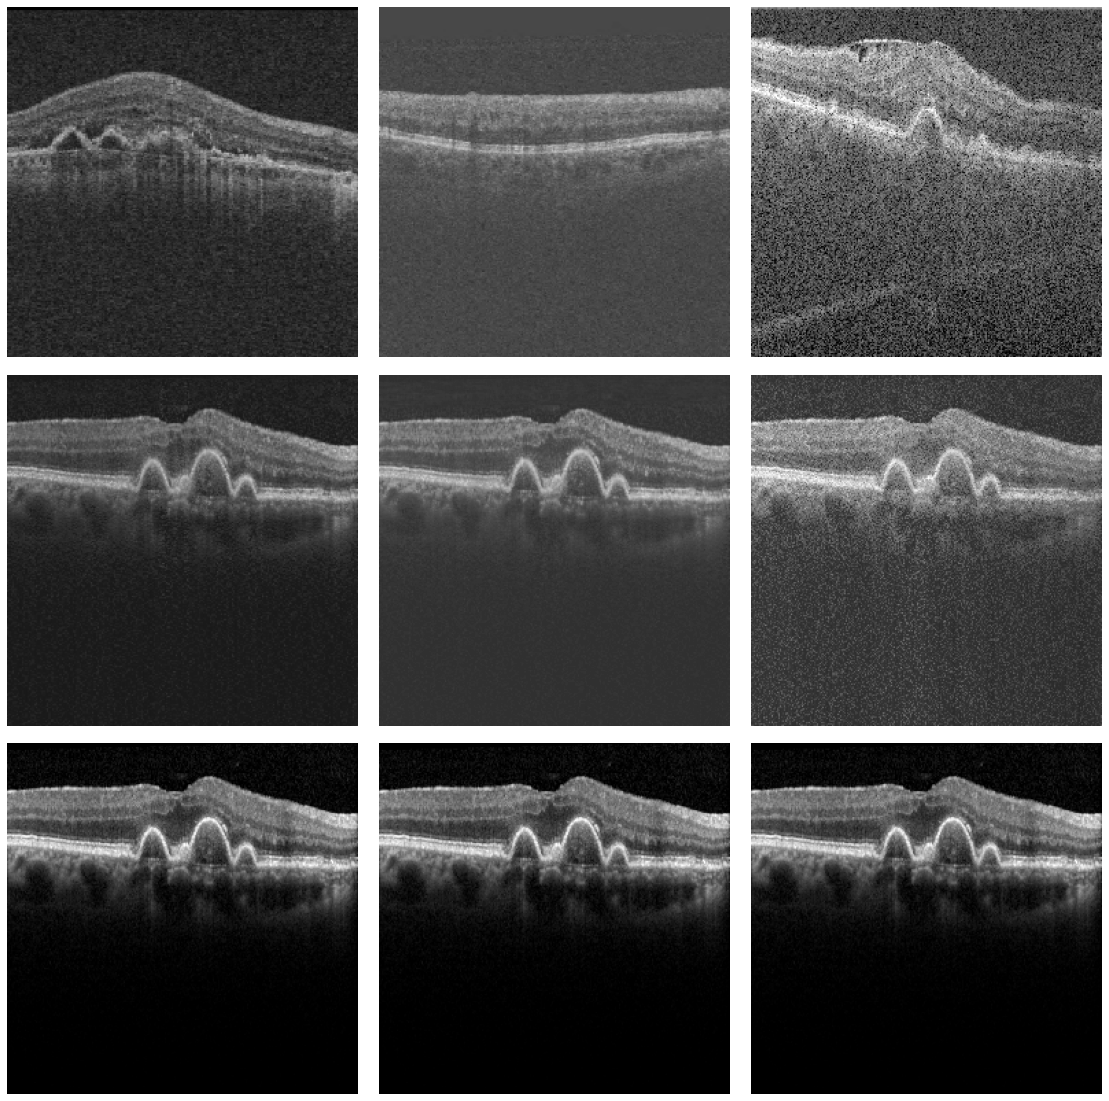

In [ ]:

cmap="gray"

fig = plt.figure(figsize=(20,20))
ax3 = fig.add_subplot(3,3,1)
ax3.imshow(resized_cirrus,cmap=cmap,vmin=0,vmax=255)

plt.title('',fontsize=30)

ax2 = fig.add_subplot(3,3,2)
ax2.imshow(resized_topcon,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)

ax4 = fig.add_subplot(3,3,3)
ax4.imshow(resized_bioptigen,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)


ax6 = fig.add_subplot(3,3,4)
ax6.axis("off")
plt.title('',fontsize=30)
ax6.imshow(svdna_im_cirrus,cmap=cmap,vmin=0,vmax=255)

ax7 = fig.add_subplot(3,3,5)
ax7.imshow(svdna_im_topcon,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)

ax8 = fig.add_subplot(3,3,6)
ax8.imshow(svdna_im_bioptigen,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)


ax9 = fig.add_subplot(3,3,7)
ax9.imshow(resized_src,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)


ax10 = fig.add_subplot(3,3,8)
ax10.imshow(resized_src,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)


ax11 = fig.add_subplot(3,3,9)
ax11.imshow(resized_src,cmap=cmap,vmin=0,vmax=255)
plt.title('',fontsize=30)

plt.subplots_adjust(wspace=0, hspace=0.05)

ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
ax6.axis("off")
ax7.axis("off")
ax8.axis("off")
ax9.axis("off")
ax10.axis("off")
ax11.axis("off")
